In [1]:
import os
import medusa
from pickle import load
import pandas as pd
import json
import numpy

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from skbio.stats.ordination import pcoa
from skbio.stats.distance import DissimilarityMatrix

In [2]:
# load the gene knockout dataframes
gene_knockout_results = {}    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    gene_knockout_results[species] = pd.read_csv(
        '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)

In [3]:
# load the ensembles, which we will need later.
# load all ensembles
ensembles = {}
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

In [4]:
# Get the ensemble feature states for each species, which will be used as input
# to regression with principle coordinates as output.
feature_frames = {}
for species in ensembles.keys():
    ensemble = ensembles[species]
    # Grab the features and states for the ensemble and convert to a dataframe
    feature_dict = {}
    for feature in ensemble.features:
        feature_dict[feature.id] = feature.states
    feature_frame = pd.DataFrame.from_dict(feature_dict)

    # Convert to a boolean dataframe for faster computation
    # (0 values become False, all others become True (i.e. active features))
    feature_frames[species] = feature_frame.astype(bool)

In [5]:
# collapse perfectly correlated features. Takes a while because of the pairwise comparison
# of contents for an entire column in each dataframe.
feature_sets = {}
for species in feature_frames.keys():
    feature_sets[species] = {}
    checkfeat = feature_frames[species].columns
    usedfeat = []
    for feature1 in checkfeat:
        if feature1 not in usedfeat:
            identical_features = [feature1]
            usedfeat.append(feature1)
            for feature2 in checkfeat:
                if feature2 is not feature1 and feature2 not in usedfeat:
                    if feature_frames[species][feature1].equals(feature_frames[species][feature2]):
                        identical_features.append(feature2)
                        usedfeat.append(feature2)
            feature_sets[species][feature1] = identical_features
    
    # save the feature set for this species for later inspection/use
    with open('../results/collapsed_features/'+species+'_collapsed_features.json','w') as jsonfile:
        json.dump(feature_sets[species],jsonfile)

In [6]:
# Apply the reduced feature sets to filter the dataframes.
# each key in the dictionary for each species represents a group of perfectly correlated features.
for species in feature_frames.keys():
    feature_frames[species] = feature_frames[species][list(feature_sets[species].keys())]

In [7]:
# Threshold the gene essentiality simulations and collapse perfectly correlated genes into a single variable
collapsed_knockouts = {}
gene_sets = {}
for species in gene_knockout_results.keys():
    # threshold to binarize the data as essential/nonessential (True for growth when knocked out)
    collapsed_knockout = gene_knockout_results[species]
    collapsed_knockout = collapsed_knockout > 1E-6
    collapsed_knockout = collapsed_knockout.loc[(collapsed_knockout == 0).sum(axis=1) != len(collapsed_knockout.columns)]
    collapsed_knockout = collapsed_knockout.loc[(collapsed_knockout == 1).sum(axis=1) < len(collapsed_knockout.columns)]
    collapsed_knockout = collapsed_knockout.T
    
    gene_sets[species] = {}
    checkgenes = collapsed_knockout.columns
    usedgene = []
    print (species)
    print("Genes before collapse: " + str(len(checkgenes)))
    
    for gene1 in checkgenes:
        if gene1 not in usedgene:
            identical_genes = [gene1]
            usedgene.append(gene1)
            for gene2 in checkgenes:
                if gene2 is not gene1 and gene2 not in usedgene:
                    if collapsed_knockout[gene1].equals(collapsed_knockout[gene2]):
                        identical_genes.append(gene2)
                        usedgene.append(gene2)
            gene_sets[species][gene1] = identical_genes
    collapsed_knockouts[species] = collapsed_knockout[list(gene_sets[species].keys())]
    print("Genes after collapse: " + str(len(collapsed_knockouts[species].columns)))
    
    # save the collapsed essentiality groups for this species for later inspection/use
    with open('../results/collapsed_essentiality/'+species+'_collapsed_essentiality.json','w') as jsonfile:
        json.dump(gene_sets[species],jsonfile)

Enterococcus faecalis
Genes before collapse: 25
Genes after collapse: 14
Streptococcus oralis
Genes before collapse: 17
Genes after collapse: 14
Listeria seeligeri
Genes before collapse: 12
Genes after collapse: 7
Haemophilus influenzae
Genes before collapse: 17
Genes after collapse: 12
Ralstonia solanacearum
Genes before collapse: 17
Genes after collapse: 6
Staphylococcus aureus
Genes before collapse: 11
Genes after collapse: 10
Haemophilus parasuis
Genes before collapse: 28
Genes after collapse: 21
Neisseria flavescens
Genes before collapse: 24
Genes after collapse: 20
Chryseobacterium gleum
Genes before collapse: 20
Genes after collapse: 11
Corynebacterium efficiens
Genes before collapse: 15
Genes after collapse: 7
Sphingobacterium spiritivorum
Genes before collapse: 20
Genes after collapse: 12
Flavobacterium johnsoniae
Genes before collapse: 26
Genes after collapse: 12
Ralstonia pickettii
Genes before collapse: 29
Genes after collapse: 12
Streptococcus vestibularis
Genes before col

Enterococcus faecalis
Streptococcus oralis
Listeria seeligeri
Haemophilus influenzae
Ralstonia solanacearum
Staphylococcus aureus
Haemophilus parasuis
Neisseria flavescens
Chryseobacterium gleum
Corynebacterium glutamicum
Sphingobacterium spiritivorum
Flavobacterium johnsoniae
Ralstonia pickettii
Streptococcus vestibularis
Bacillus pumilus
Streptococcus gallolyticus
Staphylococcus epidermidis
Neisseria meningitidis
Streptococcus mitis
Neisseria mucosa
Pseudomonas stutzeri


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Pseudomonas mendocina
Listeria monocytogenes
Aeromonas salmonicida
Pseudomonas putida
Staphylococcus haemolyticus
Corynebacterium efficiens
Streptococcus equinus
Streptococcus pneumoniae


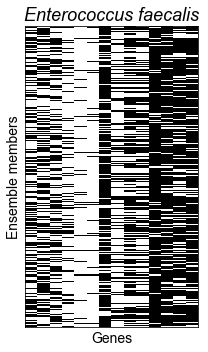

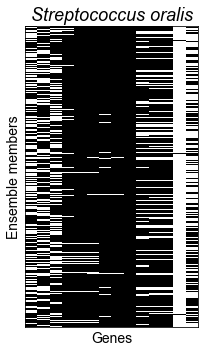

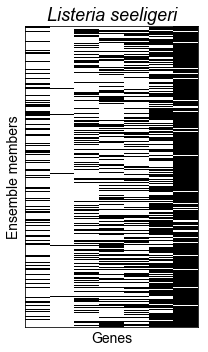

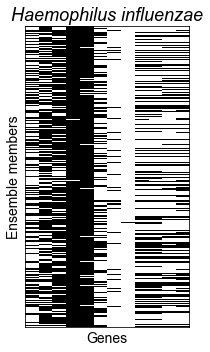

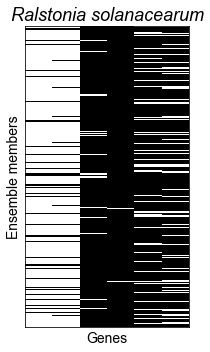

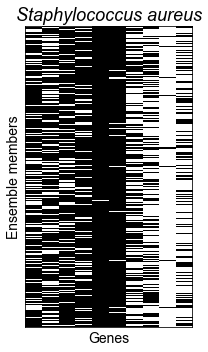

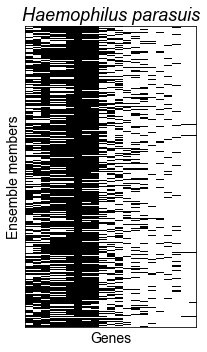

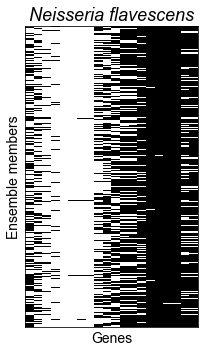

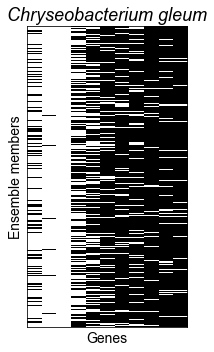

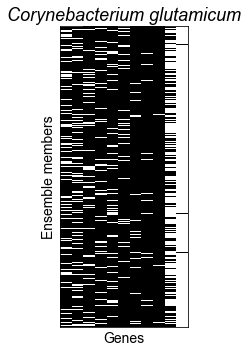

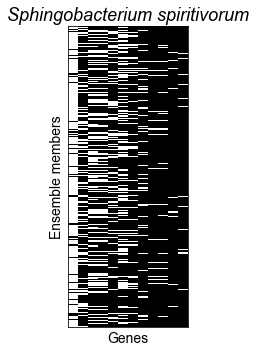

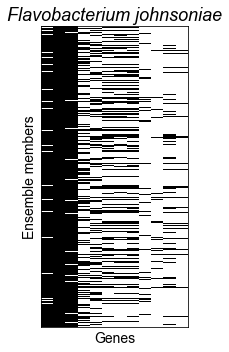

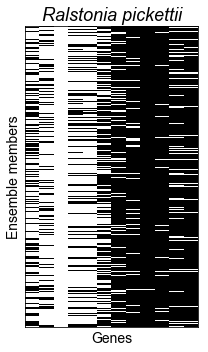

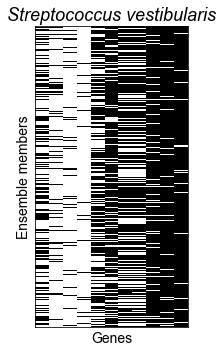

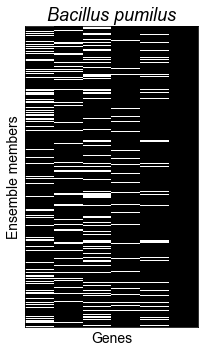

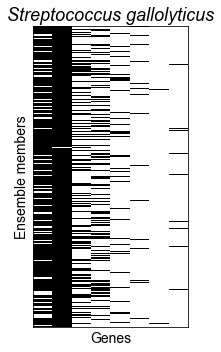

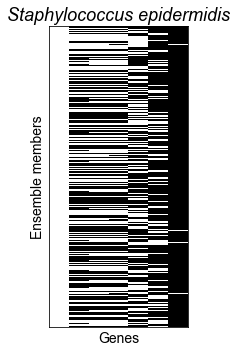

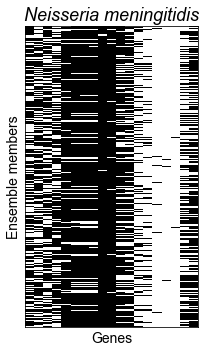

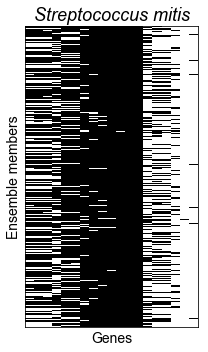

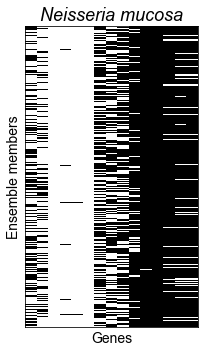

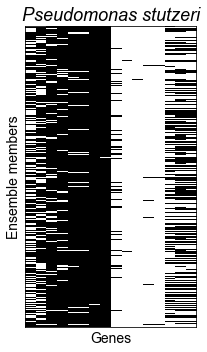

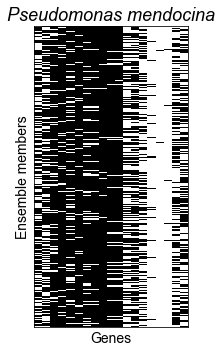

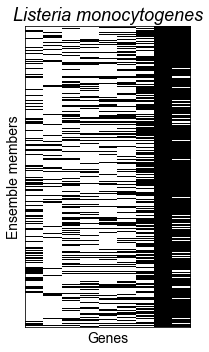

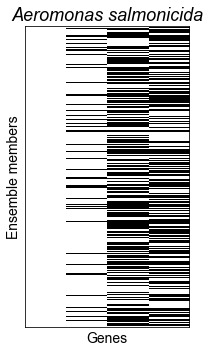

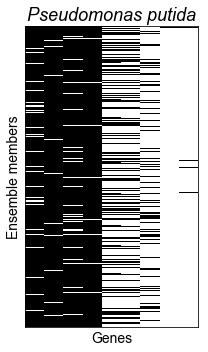

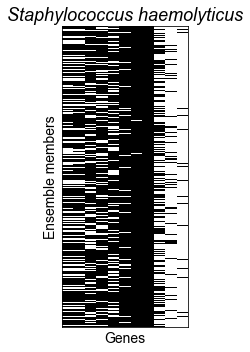

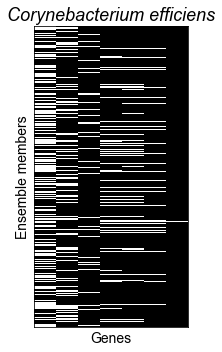

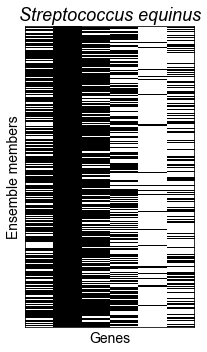

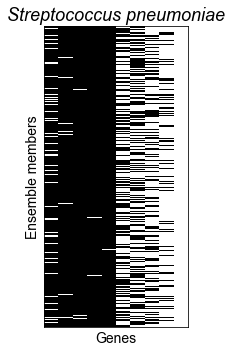

In [8]:
essentiality_ax = {}
for species in collapsed_knockouts.keys():
    if species not in exclude:
        if len(collapsed_knockouts[species].keys()) > 2:
            plotframe = collapsed_knockouts[species].T
            plotvals = plotframe.values

            # reorder by heirarchical clustering of genes
            dgram = dendrogram(linkage(pdist(plotvals,metric='hamming')),labels=plotframe.index,no_plot=True)
            plotframe = plotframe.reindex(dgram['ivl'])
            plotvals = plotframe.values

            rxn_labels = plotframe.index

            # White cells are essential, black cells are non-essential.
            print(species)
            fig, ax = plt.subplots()
            im = ax.imshow(plotvals.T,cmap='binary_r')
            ax.set_ylabel('Ensemble members',size=14)
            ax.set_xlabel('Genes',size=14)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(species,size=18,style='italic')
            ax.set_aspect('auto')
            fig.set_size_inches(3,5)
            fig.tight_layout()
            essentiality_ax[species] = ax
            fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.png')
            fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.svg')

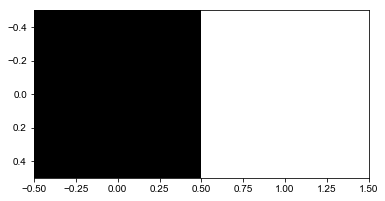

In [9]:
# Sanity check: True values are white, False values are black.
fig,ax=plt.subplots()
ax.imshow([[False,True]],cmap='binary_r')

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.064983826136836 and the largest is 35.150641228163416.


For Enterococcus faecalis:
# of members in cluster 0: 532
# of members in cluster 1: 466


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.1008225263275815 and the largest is 23.876258218202477.


For Streptococcus oralis:
# of members in cluster 0: 753
# of members in cluster 1: 234


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -10.039047895703678 and the largest is 47.63323385778975.


For Listeria seeligeri:
# of members in cluster 0: 378
# of members in cluster 1: 612


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.213156756812664 and the largest is 51.71641903075731.


For Haemophilus influenzae:
# of members in cluster 0: 329
# of members in cluster 1: 651


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.579478273826729 and the largest is 30.130281686602128.


For Ralstonia solanacearum:
# of members in cluster 0: 236
# of members in cluster 1: 755


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.956496121006691 and the largest is 22.279097644416034.


For Staphylococcus aureus:
# of members in cluster 0: 547
# of members in cluster 1: 453


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.9779169920677844 and the largest is 15.717351493816375.


For Haemophilus parasuis:
# of members in cluster 0: 314
# of members in cluster 1: 685


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.868914106203835 and the largest is 18.456933385536516.


For Neisseria flavescens:
# of members in cluster 0: 719
# of members in cluster 1: 281


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.759368217732779 and the largest is 13.269437010774638.


For Chryseobacterium gleum:
# of members in cluster 0: 476
# of members in cluster 1: 514


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.187105037561987 and the largest is 13.546710588926196.


For Corynebacterium glutamicum:
# of members in cluster 0: 594
# of members in cluster 1: 387


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.831222595256988 and the largest is 21.95930460016297.


For Sphingobacterium spiritivorum:
# of members in cluster 0: 626
# of members in cluster 1: 372


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.964261369980875 and the largest is 32.26247243009022.


For Flavobacterium johnsoniae:
# of members in cluster 0: 353
# of members in cluster 1: 646


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.067495620342415 and the largest is 17.984241714258964.


For Ralstonia pickettii:
# of members in cluster 0: 237
# of members in cluster 1: 729


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.379098024339459 and the largest is 27.213500484638903.


For Streptococcus vestibularis:
# of members in cluster 0: 325
# of members in cluster 1: 674


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.526456467341874 and the largest is 19.938581503018877.


For Bacillus pumilus:
# of members in cluster 0: 181
# of members in cluster 1: 738


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.5370238454863396 and the largest is 15.25837774529549.


For Streptococcus gallolyticus:
# of members in cluster 0: 655
# of members in cluster 1: 339


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -14.68219611789117 and the largest is 70.05587729942975.


For Staphylococcus epidermidis:
# of members in cluster 0: 512
# of members in cluster 1: 487


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.9469224033557198 and the largest is 27.97930389050532.


For Neisseria meningitidis:
# of members in cluster 0: 283
# of members in cluster 1: 703


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.025245725262848 and the largest is 20.770010350867448.


For Streptococcus mitis:
# of members in cluster 0: 356
# of members in cluster 1: 640


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.7264465241348874 and the largest is 11.187845439064299.


For Neisseria mucosa:
# of members in cluster 0: 500
# of members in cluster 1: 476


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.766052635886534 and the largest is 20.52852427955004.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Pseudomonas stutzeri:
# of members in cluster 0: 404
# of members in cluster 1: 593


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.470303421502092 and the largest is 13.145135213181739.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Pseudomonas mendocina:
# of members in cluster 0: 329
# of members in cluster 1: 651


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.47302871999752 and the largest is 42.16996475115796.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Listeria monocytogenes:
# of members in cluster 0: 640
# of members in cluster 1: 359


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -11.51597833096 and the largest is 35.283520607390805.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Aeromonas salmonicida:
# of members in cluster 0: 324
# of members in cluster 1: 456


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.5895430635959653 and the largest is 18.819836567020342.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Pseudomonas putida:
# of members in cluster 0: 326
# of members in cluster 1: 540


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.17906580209806 and the largest is 24.020707365728146.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Staphylococcus haemolyticus:
# of members in cluster 0: 623
# of members in cluster 1: 375


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.817457896010395 and the largest is 28.17148232351707.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Corynebacterium efficiens:
# of members in cluster 0: 663
# of members in cluster 1: 150


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.104467701363683 and the largest is 35.04819502278237.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Streptococcus equinus:
# of members in cluster 0: 656
# of members in cluster 1: 336


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.082685976467203 and the largest is 12.899103239404722.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/ipykernel_launcher.py:20 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/ipykernel_launcher.py:21 SettingWithCopyWarning: 
A value

For Streptococcus pneumoniae:
# of members in cluster 0: 535
# of members in cluster 1: 462


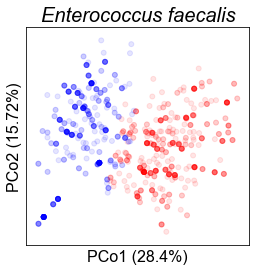

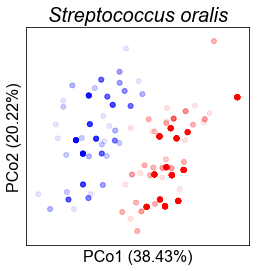

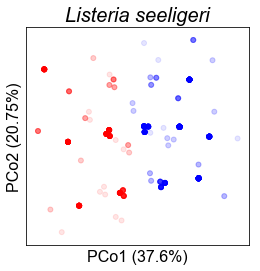

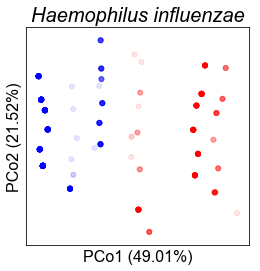

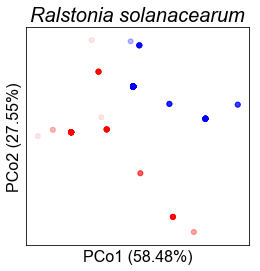

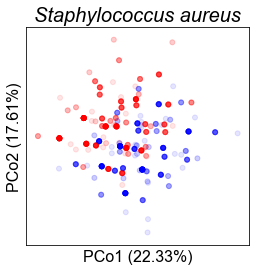

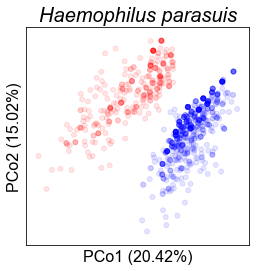

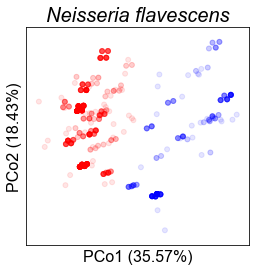

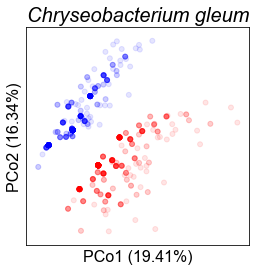

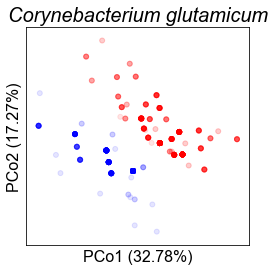

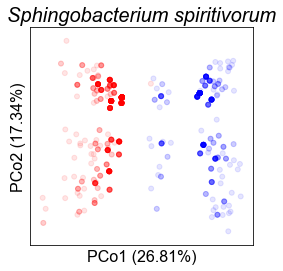

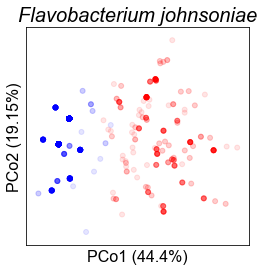

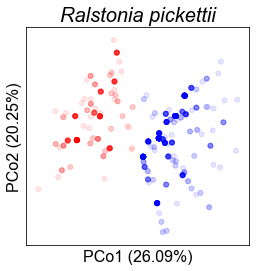

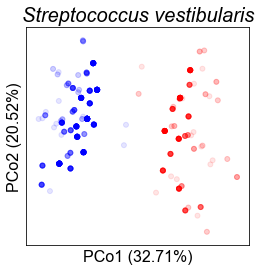

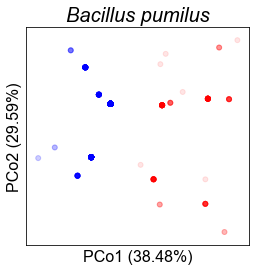

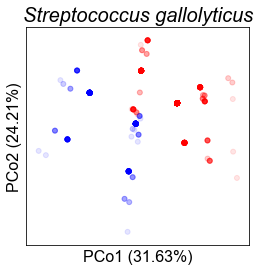

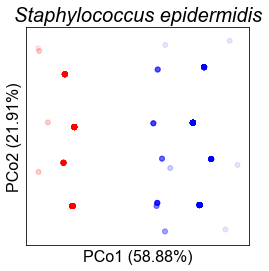

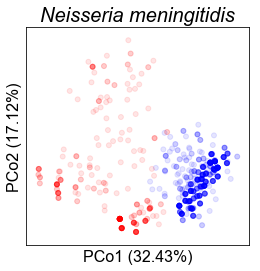

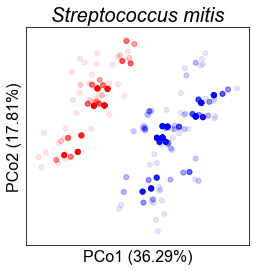

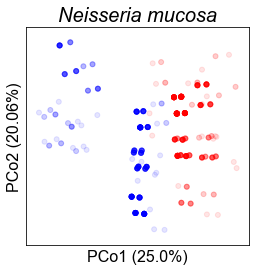

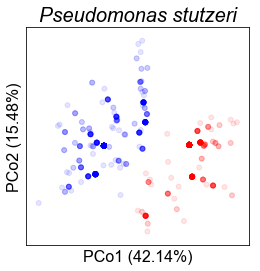

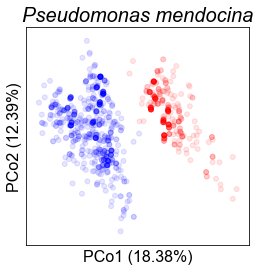

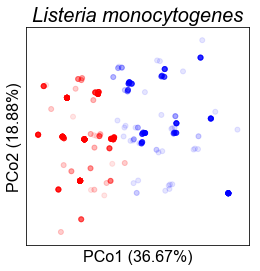

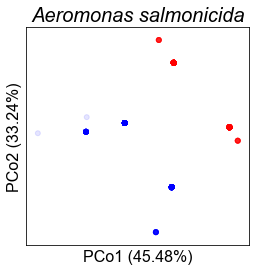

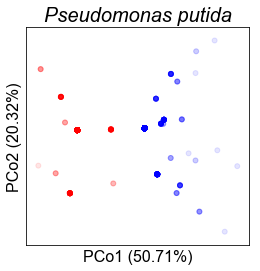

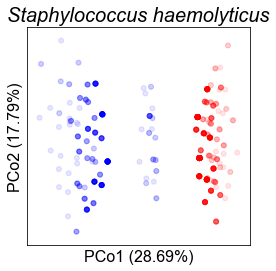

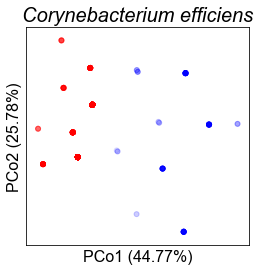

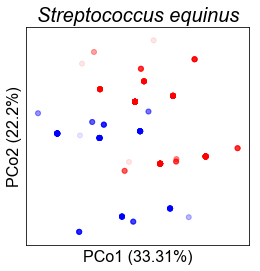

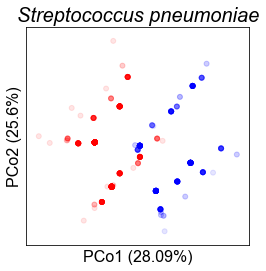

In [10]:
# Calculate the gene knockout distance between ensemble members, perform PCOA,
# assign clusters with k-means, then classify with random forest.
classifiers = {}
classifier_scores = {}
dfs_for_pcoa = {}
pc_vars = {}
for species in collapsed_knockouts.keys():
    if species not in ["Stenotrophomonas maltophilia"]:
        if len(collapsed_knockouts[species].keys()) > 2:
            df_for_pcoa = collapsed_knockouts[species]

            # perform kmeans clustering on the gene profiles to determine
            # the two clusters with maximal variance
            clust = KMeans(n_clusters = 2).fit(df_for_pcoa.values)
            
            pcoa_input = DissimilarityMatrix(squareform(pdist(df_for_pcoa,metric="hamming")),ids=df_for_pcoa.index)
            pcoa_result = pcoa(pcoa_input, number_of_dimensions=3)

            # Add scores for each sample back to the dataframes
            df_for_pcoa['PCo1'] = pcoa_result.samples['PC1'].values
            df_for_pcoa['PCo2'] = pcoa_result.samples['PC2'].values
            df_for_pcoa['cluster'] = clust.labels_

            # grab the ensembles feature frame, fit the classifier
            feature_frame = feature_frames[species]
            input_cols = feature_frame.columns
            df_for_pcoa = df_for_pcoa.merge(feature_frame,left_index=True,right_index=True)
            # perform binary classification using random forest
            classifiers[species] = RandomForestClassifier(n_estimators=500, oob_score=True).fit(
                df_for_pcoa[input_cols],df_for_pcoa['cluster'])


            # get variance explained for PC1/PC2
            pc1_var = pcoa_result.proportion_explained[0]#pipe_w_scale.named_steps.pca.explained_variance_[0]
            pc2_var = pcoa_result.proportion_explained[1]#pipe_w_scale.named_steps.pca.explained_variance_[1]
            pc_vars[species] = {}
            pc_vars[species]['PCo1'] = pc1_var
            pc_vars[species]['PCo2'] = pc2_var
            
            fig, ax = plt.subplots()
            colors = ['red','blue']
            clust_color = [colors[i] for i in df_for_pcoa['cluster']]
            cmap=matplotlib.colors.ListedColormap(colors)
            ax.scatter(df_for_pcoa['PCo1'],df_for_pcoa['PCo2'],marker='o',
                    c=clust_color,cmap=cmap,alpha = 0.1,s=25)
            ax.set_title(species,fontsize=20,style='italic')
            ax.set_xlabel('PCo1 (%s%%)' % str(numpy.round(100*pc1_var,decimals=2)), fontsize=16)
            ax.set_ylabel('PCo2 (%s%%)' % str(numpy.round(100*pc2_var,decimals=2)), fontsize=16)
            ax.axes.get_yaxis().set_ticks([])
            ax.axes.get_xaxis().set_ticks([])
            fig.set_size_inches(4,4)
            fig.savefig('../results/gene_knockout_pcoa_plots/'+species+'_gene_ko_pcoa.png')
            fig.savefig('../results/gene_knockout_pcoa_plots/'+species+'_gene_ko_pcoa.svg')
            
            # Save the classifier importances, cluster labels, and % of each cluster
            # that contain a feature
            imp_frame = pd.DataFrame(classifiers[species].feature_importances_,
                                            index=feature_frames[species].columns).sort_values(
                                            by=0,ascending=False)
            imp_frame.columns = ['importance']
            
            feature_matrix = pd.DataFrame()
            for feature in imp_frame.index.tolist():
                feat_obj = ensembles[species].features.get_by_id(feature)
                feature_df = pd.DataFrame.from_dict(feat_obj.states,orient='index')
                # binarize the feature df
                feature_df = abs(feature_df) > 1E-6
                feature_df.columns = [feature]
                feature_matrix = feature_matrix.join(feature_df,how='outer')
            
            # add cluster info to the feature matrix
            feature_matrix = feature_matrix.join(pd.DataFrame(df_for_pcoa['cluster']),how='outer')
            # Get the fraction of members in each cluster that contain each feature
            frac = {}
            print('For ' + species + ':')
            for group,frame in feature_matrix.groupby('cluster'):
                frac[group] = frame.sum(axis=0)/len(frame.index)
                print('# of members in cluster '+str(group)+ ': ' +str(len(frame.index)))
                # add the fraction information to the importance frame
                imp_frame['fraction active in '+str(group)] = frac[group]
            
            imp_frame.to_csv('../results/classification_results/'+species+'_feature_importance.csv',sep=',')

            # save the cluster membership information
            df_for_pcoa['cluster'].to_csv('../results/classification_results/'+species+'_clusters.csv',sep=',')
    
            # save each species' pcoa dataframe to plot them all together
            dfs_for_pcoa[species] = df_for_pcoa
            
            # record calssifier performance
            classifier_scores[species] = classifiers[species].oob_score_

# Save the performance results
with open('../results/classification_results/perfomance.json','w') as outfile:
    json.dump(classifier_scores,outfile)

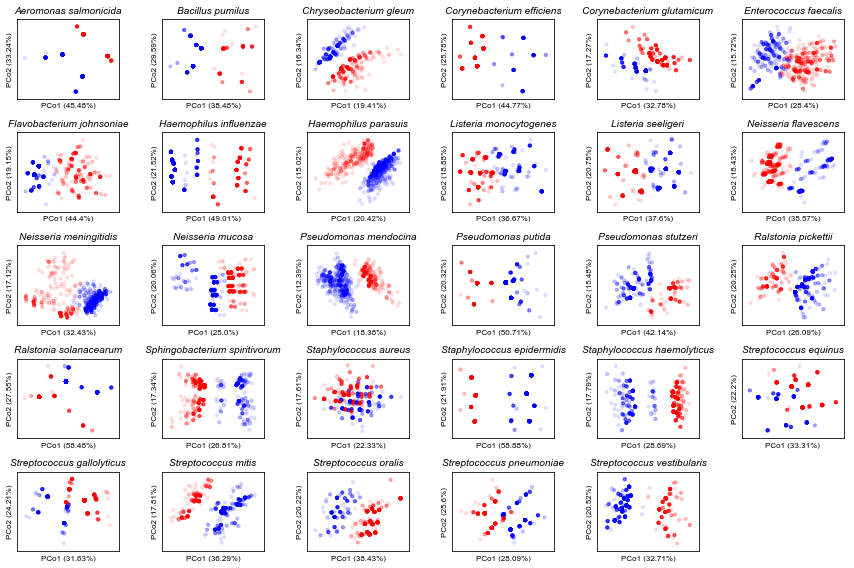

In [11]:
# Generate a single, large multipanel plot to show all of the results
classifiers = {}
classifier_scores = {}
pcoa_ax = {}

fig, axes = plt.subplots(5,6)
axes = numpy.ravel(axes)
j = 0

sorted_species = list(dfs_for_pcoa.keys())
sorted_species.sort()

for species in sorted_species:
            df_for_pcoa = dfs_for_pcoa[species]

            ax = axes[j]
            colors = ['red','blue']
            clust_color = [colors[i] for i in df_for_pcoa['cluster']]
            cmap=matplotlib.colors.ListedColormap(colors)
            ax.scatter(df_for_pcoa['PCo1'],df_for_pcoa['PCo2'],marker='o',
                    c=clust_color,cmap=cmap,alpha = 0.1,s=10)
            ax.set_title(species,fontsize=10,style='italic')
            ax.set_xlabel('PCo1 (%s%%)' % str(numpy.round(100*pc_vars[species]['PCo1'],decimals=2)), fontsize=8)
            ax.set_ylabel('PCo2 (%s%%)' % str(numpy.round(100*pc_vars[species]['PCo2'],decimals=2)), fontsize=8)
            ax.axes.get_yaxis().set_ticks([])
            ax.axes.get_xaxis().set_ticks([])
            j += 1

while j < len(axes):
    fig.delaxes(axes[j])
    j += 1
fig.set_size_inches(12,8)
fig.tight_layout()
fig.savefig('../results/gene_knockout_pcoa_plots/all_pcoa.svg')
fig.savefig('../results/gene_knockout_pcoa_plots/all_pcoa.png')